# Santa's 2019 : Original Genetic Algorithm method

## Import

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import time 
import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# to save 
import pickle
from sklearn.externals import joblib

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) 
# will list all files under the input directory

import os
from numba import njit, jit

In [3]:
# The name of the kernel might change, so update this if needed
#from santa_s_2019_faster_cost_function_24_s import build_cost_function

## Definitions

In [4]:
# Paths to folders/files
# KAGGLE
#PATH_INPUT = '/kaggle/input' #for kaggle
#PATH_TO_SAVE_DATA = '/kaggle/working' #for kaggle

# LOCAL
PATH_INPUT = 'kaggle/input'
PATH_TO_SAVE_DATA = "../../data"

# ALL
PATH_SAVE_PROB_FAM = PATH_TO_SAVE_DATA + '/df_prob_fam.pkl'
PATH_SAVE_DF_POP = PATH_TO_SAVE_DATA + '/df_pop.pkl'
PATH_SAVE_DF_POP_10 = PATH_TO_SAVE_DATA + '/df_pop_10.pkl'

# Data information
DAY_RANGE = list(range(1, 101)) # day before Christmas
DAY_RANGE_MIN = np.min(DAY_RANGE) 
DAY_RANGE_MAX = np.max(DAY_RANGE) 

# Hyper-parameters:
NB_FIRST_POP = 1000 # number of first population of choices 
R_FIRST_MUT = 0.01 # RATIO of mutation for first population
R_POP_MUT = 0.05 # RATIO of population mutation after first generation
R_MUT = 0.01 # RATIO of number of family choices mutated
DELTA_DAYS = 1 # delta of days around previous best day for generation/mutation
R_POP_LOST = 0.01 # Ratio of lost individuals in population 
NB_MAX_EPOCHS = 1000
# method 2 : by choices
DELTA_CHOICE = 1
CHOICE_RANGE_MIN = 0
CHOICE_RANGE_MAX = 10

In [5]:
for dirname, _, filenames in os.walk(PATH_INPUT):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

kaggle/input/.DS_Store
kaggle/input/santa-2019-workshop-scheduling/family_data.csv
kaggle/input/santa-2019-workshop-scheduling/sample_submission.csv


## Useful functions

In [94]:
def find_choice_range(choice_curr):
    '''
    select range of choices 
    from random between +/- delta choice around choice_curr
    
    return a range
    '''
    choice_min = np.min([np.max([CHOICE_RANGE_MIN, choice_curr - DELTA_CHOICE]), 
                          CHOICE_RANGE_MAX - 2 * DELTA_CHOICE])
    choice_max = np.min([CHOICE_RANGE_MAX, 
                        np.max([CHOICE_RANGE_MIN + 2 * DELTA_CHOICE, 
                        choice_curr + DELTA_CHOICE])]) + 1
    range_choice = range(choice_min, choice_max)
    
    return range_choice

@njit
def find_choice_range_optim(choice_curr):
    '''
    select range of choices 
    from random between +/- delta choice around choice_curr
    
    return a range
    '''
    #return max(choice_curr, CHOICE_RANGE_MIN)
    
    
    choice_min = min(max(CHOICE_RANGE_MIN, choice_curr - DELTA_CHOICE), 
                          CHOICE_RANGE_MAX - 2 * DELTA_CHOICE)
    choice_max = min(CHOICE_RANGE_MAX, 
                        max(CHOICE_RANGE_MIN + 2 * DELTA_CHOICE, 
                        choice_curr + DELTA_CHOICE)) + 1
    range_choice = np.arange(choice_min, choice_max)
    
    return range_choice


def find_choice_from_day(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    '''
    fam_days = data_choice.loc[fam_id]
    
    idx_choice_curr = fam_days[day_curr == fam_days].index
    
    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]

def find_choice_from_day_arr(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    '''
    idx_choice_curr = np.nonzero(arr_choice[fam_id,:] == day_curr)[0]

    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]

@njit
def find_choice_from_day_optim(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    '''
    idx_choice_curr = np.nonzero(arr_choice[fam_id,:] == day_curr)[0]

    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]
    
    
def choose_day_prob(choice_curr, fam_id):
    '''
    find or choose the day of given choice number according to family choices
    
    if choice 10, then find a day randomly
    
    return a day
    '''
  
    choice_curr = np.array(choice_curr)
    
    vect_days_choice = data_choice.loc[fam_id, np.minimum(9, choice_curr)]
    vect_days_choice = np.array(vect_days_choice)
    
    idx_choice_10 = np.nonzero(choice_curr == 10)[0]
    if idx_choice_10.shape[0] > 0:
        nb_10 = idx_choice_10.shape[0]
        vect_all_days = np.array(range(1, 101))
        vect_prob_10 = np.array(df_prob_fam.astype("float").loc[fam_id])/ \
            df_prob_fam.loc[fam_id].sum()
        #vect_prob_10 = np.ones(vect_all_days.shape[0])
        vect_prob_10[idx_choice_10] = 0
        vect_prob_10 = vect_prob_10 / np.sum(vect_prob_10)
        days_10 = np.random.choice(vect_all_days, size=nb_10,
                                  p=vect_prob_10)
        #print("idx_choice_10: ", idx_choice_10)
        for i_day, indice in enumerate(idx_choice_10):
            
            if vect_days_choice.shape:
                
                ''' print("days_10: ", days_10)
                print("vect_days_choice: ", np.array(vect_days_choice))
                print("vect_days_choice[indice]: ", 
                      np.array(vect_days_choice)[indice])
                print("i_day: ", i_day)
                print("days_10[i_day]: ", days_10[i_day])
                print("indice : ", indice)'''

                vect_days_choice[indice] = days_10[i_day]
            else:
                vect_days_choice = np.array(days_10[i_day])
            
        return vect_days_choice
    else:
        return vect_days_choice
    
def choose_day_prob_arr(choice_curr, fam_id):
    '''
    find or choose the day of given choice number according to family choices
    
    if choice 10, then find a day randomly
    
    return a day
    '''
    choice_curr = np.array(choice_curr)
    
    vect_days_choice = arr_choice[fam_id, np.minimum(9, choice_curr)]
    #vect_days_choice = np.array(vect_days_choice)
    
    idx_choice_10 = np.nonzero(choice_curr == 10)[0]
    if idx_choice_10.shape[0] > 0:
        nb_10 = idx_choice_10.shape[0]
        vect_all_days = np.array(range(1, 101))
        vect_prob_10 = arr_prob_fam[fam_id]/arr_prob_fam[fam_id].sum()
        #np.array(df_prob_fam.astype("float").loc[fam_id])/ \
        #    df_prob_fam.loc[fam_id].sum()
        #vect_prob_10 = np.ones(vect_all_days.shape[0])
        vect_prob_10[idx_choice_10] = 0
        vect_prob_10 = vect_prob_10 / np.sum(vect_prob_10)
        days_10 = np.random.choice(vect_all_days, size=nb_10,
                                  p=vect_prob_10)
        #print("idx_choice_10: ", idx_choice_10)
        for i_day, indice in enumerate(idx_choice_10):
            
            if vect_days_choice.shape:
                
                vect_days_choice[indice] = days_10[i_day]
            else:
                vect_days_choice = np.array(days_10[i_day])
            
        return vect_days_choice
    else:
        return vect_days_choice    

@njit
def choose_day_prob_optim(choice_curr, fam_id):
    #def choose_day_prob_optim(choice_curr, fam_id, arr_choice=arr_choice):
    '''
    V1.1 : correction about no selection of days choices for choice 10 
    
    find or choose the day of given choice number according to family choices
    
    if choice 10, then find a day randomly
    
    return a day
    '''
    #choice_curr = np.array(choice_curr)
        
    idx_choice_10 = []
    for I in np.arange(choice_curr.shape[0]):
        if choice_curr[I] == 10:
            idx_choice_10.append(I)
            
    idx_choice_10 = np.array(idx_choice_10)
    
    vect_days_choice = []
    for J in np.arange(choice_curr.shape[0]):
        vect_days_choice.append(arr_choice[fam_id, 
                                           np.minimum(9, choice_curr[J])])
        
    vect_days_choice = np.array(vect_days_choice)
    #print("idx_choice_10 " , idx_choice_10)
    if idx_choice_10.shape[0] > 0:
        nb_10 = idx_choice_10.shape[0]
        vect_all_days = np.arange(1, 101)
        vect_prob_10 = arr_prob_fam[fam_id].copy()
        vect_prob_10[arr_choice[fam_id]] = 0
        vect_prob_10 = vect_prob_10 / np.sum(vect_prob_10)
        #print("vect_prob_10 ",vect_prob_10)
        days_10 = rand_choice_nb(vect_all_days, size=nb_10,
                                  prob=vect_prob_10)
        #print("days_10 ", days_10)
        for i_day, indice in enumerate(idx_choice_10):
            vect_days_choice[indice] = days_10[i_day]         
        return vect_days_choice
    else:
        return vect_days_choice 

def mutation_day(day_curr, fam_id, nb_mut=1, flag_prob=False):
    # function mutation of days : around choices
    # day_curr -> choice_curr -> range choices -> 
    # choose randomly 1 choice -> 1 day 
    # fam_id = 0
    # day_curr = 100
    # mutation_day(day_curr, fam_id, 10)
    choice_curr = find_choice_from_day_arr(day_curr, fam_id)
    #print("choice_curr: ", choice_curr)
    range_choices = find_choice_range(choice_curr)
    #print("range_choices: ", np.array(range_choices))
    
    if flag_prob:
        vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
        #np.array(df_prob.loc[data.loc[fam_id,"n_people"], 
        #                     ['choice_{}'.format(i) for i in range_choices]])
        vect_prob = vect_prob / vect_prob.sum()
        #print("vect_prob: ", vect_prob)
        choice_new = np.random.choice(range_choices, size=nb_mut,
                                     p=vect_prob)
    else:
        choice_new = np.random.choice(range_choices, size=nb_mut)
        
    #print("choice_new: ", choice_new)
    return choose_day_prob_arr(choice_new, fam_id)


def find_day_range(day_curr):
    '''
    select range of days from random between +/- delta day around day_curr
    
    return a range
    '''
    day_min = np.min([np.max([DAY_RANGE_MIN, day_curr-DELTA_DAYS]), 
                      DAY_RANGE_MAX - 2 * DELTA_DAYS])
    day_max = np.min([DAY_RANGE_MAX, np.max([DAY_RANGE_MIN + 2 * DELTA_DAYS, 
                                             day_curr + DELTA_DAYS])]) + 1
    range_day = range(day_min, day_max)

    return range_day


def generate_pop(seed_indiv=None, nb_pop=None, r_mut=None):
    '''
    Generate first polulation from one seed individual
    - seed_indiv # best submission 
    - nb_pop # number of individual
    - r_mut # ratio of individual who mutate for each family
    
    return dataFrame population
    '''
    t_fit_0 = time.time()
    # GENERATION OF FIRST POP:
    print("Generating population : ")
    # definitions:
    if seed_indiv is None:
        seed_indiv = submission
    if nb_pop is None:
        nb_pop = NB_FIRST_POP
    if r_mut is None:
        r_mut = R_FIRST_MUT
    #print("seed_indiv: ", seed_indiv)
    print("nb_pop: ", nb_pop)
    print("r_mut: ", r_mut)
    # initialize with same previous best indiv.
    df_pop = pd.DataFrame(index=range(0, nb_pop), 
                          columns=seed_indiv["family_id"])

    for fam_id in seed_indiv["family_id"]:
        df_pop[fam_id] = seed_indiv.at[fam_id,'assigned_day']

    # create nb_pop family choices from baseline :
    # use probabilies
    # df_pop : contains number choices of all the population of 5000 families
    # df_pop = f(indiv., family)
    # for each family, create n choice among their first choice
    # use day probabilities specific for each family
    for fam_id in data.index: # data = f(family, num choice)
        # day current is the old best seed_indiv day for this family
        day_curr = seed_indiv.at[fam_id, 'assigned_day']
        # find range around day curr +/- DELTA
        range_curr = find_day_range(day_curr)
        # retrict probabilities to range. use df_prob_fam = f(fam_id, day)
        day_prob = df_prob_fam.astype("float").loc[fam_id, range_curr]/ \
            df_prob_fam.loc[fam_id, range_curr].sum()
        # choose randomly with probabilities days around old best day
        vect_pop_mutated = np.random.choice(np.array(range_curr), 
                                size=nb_pop, 
                                p=np.array(day_prob))

        # apply the new days only a part of pop : r_mut [-]
        range_mut = np.random.choice(range(0, nb_pop), 
                                     size=int(r_mut*nb_pop))

        df_pop.loc[range_mut, fam_id] = vect_pop_mutated[range_mut]

    # keep the best : 
    df_pop.loc[0] = seed_indiv['assigned_day']
    
    print("Generation population is done.")
    t_fit_1 = time.time()
    print("Timing : ", t_fit_1 - t_fit_0)
    
    return df_pop

@njit
def generate_crossing(arr_pop_in):
    '''
    function to generate crossing
    2 parents give 2 children
    Crossing point is randomly chosen
    
    input the current poulation array
    
    return new array of whole population
    '''
    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 
    # create pairs : ramdomly
    arr_pop = arr_pop_in.copy()
    vect_indiv = np.arange(arr_pop.shape[0])
    vect_fam = np.arange(arr_pop.shape[1])
    vect_fam = vect_fam[2:-2]
    
    # method 1 : each 2 parents create 2 children (by replacement)
    arr_pairs = np.random.choice(vect_indiv, replace=False,
                        size=(int(arr_pop.shape[0]/2), 2))
    
    
    # loop over pairs of indiv.
    for indice in np.arange(arr_pairs.shape[0]):
        id_0 = arr_pairs[indice, 0]
        id_1 = arr_pairs[indice, 1]
        
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(vect_fam)
        
        # find parts of first new indiv    
        vect_id_0_part_0 = arr_pop[id_0].take(np.arange(fam_id_cross))
        vect_id_0_part_1 = arr_pop[id_1].take(np.arange(fam_id_cross, 
                                                   arr_pop.shape[1]))
    
        # find parts of second new indiv
        vect_id_1_part_0 = arr_pop[id_1].take(np.arange(fam_id_cross))
        vect_id_1_part_1 = arr_pop[id_0].take(np.arange(fam_id_cross, 
                                                  arr_pop.shape[1])) 
    
        # replace 2 parents by 2 children
        arr_pop[id_0,:] = np.concatenate((vect_id_0_part_0, vect_id_0_part_1))
        arr_pop[id_1,:] = np.concatenate((vect_id_1_part_0, vect_id_1_part_1))
      
    return arr_pop



def create_df_prob_day_fam(df_prob_day, df_prob):
    df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index)
    for fam_id in df_prob_fam.index:
        # give at first to each families the same day probabilities
        df_prob_fam.loc[fam_id] = df_prob_day["prob"]
        # and add prob for each day choosen by families
        for choice in list_choice_all: 
            prob_curr = df_prob.at[data.at[fam_id, "n_people"], choice]
            day_curr = data.at[fam_id, choice]
            # add this prob of these days to family into df_prob_fam
            df_prob_fam.loc[fam_id, day_curr] += prob_curr
            #print(day_curr)
            #print(prob_curr)
        df_prob_fam.loc[fam_id] = \
            df_prob_fam.loc[fam_id] / df_prob_fam.loc[fam_id].sum()
    return df_prob_fam

def create_df_prob_day_fam_optim(df_prob_day, df_prob):
    '''
    Creation of probabilities for each families and each days
    
    info : Optimized version
    
    input : df_prob_day, df_prob
    ouput : df_prob_fam
    '''
    
    arr_prob_fam = np.zeros([data.shape[0], df_prob_day.shape[0]])
    arr_prob = np.array(df_prob)
    list_choice_all = ['choice_{}'.format(n) for n in range(0, 10)]
    arr_data = np.array(data.filter(items=list_choice_all))
    for fam_id in np.arange(data.shape[0]):
        # give at first to each families the same day probabilities
        
        #df_prob_fam.loc[fam_id] = df_prob_day["prob"]
        arr_prob_fam[fam_id] = df_prob_day["prob"].values
        # and add prob for each day choosen by families
        for choice in np.arange(df_prob.shape[1]-1): 
            prob_curr = arr_prob[family_size_dict[fam_id]-2, choice]
            day_curr = arr_data[fam_id, choice]
            # add this prob of these days to family into df_prob_fam
            arr_prob_fam[fam_id, day_curr-1] += prob_curr
            #print(day_curr)
            #print(prob_curr)
        arr_prob_fam[fam_id] = \
            arr_prob_fam[fam_id] / arr_prob_fam[fam_id].sum()
        
    df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index, 
                              data = arr_prob_fam)
    
    return df_prob_fam

def generate_pop_choices(seed_indiv=None, nb_pop=None, r_mut=None):
    '''
    Generate first polulation from one seed individual by family choices
    - seed_indiv # best submission 
    - nb_pop # number of individual
    - r_mut # ratio of individual who mutate for each family
    
    return dataFrame population
    '''
    t_fit_0 = time.time()
    # GENERATION OF FIRST POP:
    print("Generating population : ")
    # definitions:
    if seed_indiv is None:
        seed_indiv = submission
    if nb_pop is None:
        nb_pop = NB_FIRST_POP
    if r_mut is None:
        r_mut = R_FIRST_MUT
    #print("seed_indiv: ", seed_indiv)
    print("nb_pop: ", nb_pop)
    print("r_mut: ", r_mut)
    # initialize with same previous best indiv.
    df_pop = pd.DataFrame(index=range(0, nb_pop), 
                          columns=seed_indiv["family_id"])

    for fam_id in seed_indiv["family_id"]:
        df_pop[fam_id] = seed_indiv.at[fam_id,'assigned_day']

    # create nb_pop family choices from baseline :
    # use probabilies
    # df_pop : contains number choices of all the population of 5000 families
    # df_pop = f(indiv., family)
    # for each family, create n choice among their first choice
    # use day probabilities specific for each family
    for fam_id in data.index: # data = f(family, num choice)
        # day current is the old best seed_indiv day for this family
        day_curr = seed_indiv.at[fam_id, 'assigned_day']
        
        vect_pop_mutated = mutation_day_optim(day_curr, fam_id, nb_mut=nb_pop, 
                                        flag_prob=True)
        
        # apply the new days only a part of pop : r_mut [-]
        range_mut = np.random.choice(range(0, nb_pop), 
                                     size=int(r_mut*nb_pop))

        df_pop.loc[range_mut, fam_id] = vect_pop_mutated[range_mut]

    # keep the best : 
    df_pop.loc[0] = seed_indiv['assigned_day']
    
    print("Generation population is done.")
    t_fit_1 = time.time()
    print("Timing : ", t_fit_1 - t_fit_0)
    
    return df_pop

@njit
def rand_choice_nb(arr, size=1, prob=None):
    """
    numba compatible vesrion of np.random.choice(arr, size=size, prob=prob)
    
    :param arr: A 1D numpy array of values to sample from.
    :param prob: A 1D numpy array of probabilities for the given samples.
    :return: A random sample from the given array with a given probability.
    
    source : https://github.com/numba/numba/issues/2539
    """
    if prob is not None:
        list_value=[]
        for I in np.arange(size):
            list_value.append(arr[np.searchsorted(np.cumsum(prob), 
                                                  np.random.random(), 
                                                  side="right")])
        return np.array(list_value)
    else:
        return np.random.choice(arr, size=size)

@njit
def generate_crossing_prob(arr_pop_in, p=None , n_indiv=None):
    '''
    function to generate crossing indiv  (version with probabilities)
    V1.1 : add force create new child if same parents by changing parent
           and limitation to start - 1 end end - 1 for crossing point.
    
    2 parents give 1 child
    
    Crossing point is randomly chosen
    
    input the current population array
    
    return new array of whole population
    
    EXAMPLE : 
    arr_test = np.array([[1,2,3,4,5,6,7,8,9,10], [4,5,8,9,5,5,5,5,5,5],
                    [1,1,1,1,5,5,5,5,5,5], [6,6,6,6,6,9,9,9,9,9], 
                    [6,6,6,6,6,9,9,9,9,9]])
    arr_prob_test = 1 / np.array([1,2,3,4,5])
    arr_prob_test = arr_prob_test / np.sum(arr_prob_test)
    arr_test_new = generate_crossing_prob(arr_test, p=arr_prob_test, n_indiv=11)
    plt.plot(arr_test_new[0]-arr_test[1])
    
    '''
    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 
    # create pairs : ramdomly
    #arr_pop = arr_pop_in.copy()
    arr_pop = np.zeros((int(n_indiv), arr_pop_in.shape[1]), dtype=np.int64)
    #print('arr_pop.shape :', arr_pop.shape)
    vect_parents = np.arange(arr_pop_in.shape[0])
    #print('vect_indiv.shape :', vect_indiv.shape)
    vect_fam = np.arange(arr_pop.shape[1])
    # to NOT replacing all part of parents
    vect_fam = vect_fam[1:-1]
    # method 2 : select best ones more frequently first
    arr_pairs = np.zeros((int(n_indiv), 2), dtype=np.int64)
    for I in np.arange(int(arr_pairs.shape[0])):
        K=0
        # check and force to new children from same parents
        # patch dirty ! but njit doenst work with random choice prob 
        # & non replace...
        while (arr_pairs[I,0] == arr_pairs[I,1]) & (K < 1000):
            arr_pairs[I] = rand_choice_nb(vect_parents, size=2, prob=p)
            # test if same indiv : 
            while not(np.any(arr_pop_in[arr_pairs[I,0]] - \
                             arr_pop_in[arr_pairs[I,1]])) & (K < 1000):
                #print('arr_pairs[I,0] ', arr_pairs[I,0])
                #print('arr_pairs[I,1] ', arr_pairs[I,1])
                arr_pairs[I] = rand_choice_nb(vect_parents, size=2, prob=p)
                
                #print("K:",K)
                K=K+1
            K=K+1
            
        #print("test same:", not(np.any(arr_pop_in[arr_pairs[I,0]] - \
        #                     arr_pop_in[arr_pairs[I,1]])))
        #print(arr_pairs[I])
    #print('arr_pairs ', arr_pairs)
    #print("arr_pop ", arr_pop)
    # for all pairs wanted as output  
    for indice in np.arange(int(arr_pairs.shape[0])):
        # indice of 2 parents
        id_0 = arr_pairs[indice, 0]
        id_1 = arr_pairs[indice, 1]
        
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(vect_fam)
        
        # find parts of first new indiv    
        vect_id_0_part_0 = arr_pop_in[id_0].take(np.arange(fam_id_cross))
        vect_id_0_part_1 = arr_pop_in[id_1].take(np.arange(fam_id_cross, 
                                                   arr_pop_in.shape[1]))
        # create  children #1
        arr_pop[indice] = np.concatenate((vect_id_0_part_0, 
                                            vect_id_0_part_1))  
    return arr_pop


def find_max_same_indiv(arr_pop):
    '''
    Counts max number of same indiv among population
    return only max number of same indiv
    '''
    arr_unique, arr_counts = np.unique(arr_pop, axis=0, return_counts=True)
    nb_same_indiv = np.max(arr_counts) - 1
    return nb_same_indiv

def boost_diff_browsing(choice_matrix=choice_matrix, best=best, 
                        arr_range=arr_range):
    '''
    Boosting simple by seeking by range
    
    example :
    arr_sub, arr_score = boost_diff_browsing()
    
    '''
    # Create baselines # optimized version
    t_fit_0 = time.time()
    # Create baselines # optimized version
    start_cost = cost_function_optim(np.array(best))
    print("Start cost: ", start_cost)
    
    # prepare output : best submission seeking in different range walk around
    arr_sub = np.zeros((arr_range.shape[0], best.shape[0])).astype(np.int64)
    arr_score = np.zeros(arr_range.shape[0])
    
    for indice in np.arange(arr_range.shape[0]):

        # initiate first inviduate 
        new = best.copy()
        cost_best = start_cost
        
        # choose current range in df_range
        range_optim = arr_range[indice]
        # loop over each family with this current range
       
        for fam_id in range_optim:
            # loop over each family choice
            for pick in range(10):
                day = choice_matrix[fam_id, pick]
                temp = new.copy()
                temp[fam_id] = day # add in the new pick
        
                cost_curr = cost_function_optim(temp) # test cost
                
                if cost_curr < cost_best:
                    new = temp.copy()
                    cost_best = cost_curr
                    #print("Current best cost: ", cost_best)

        arr_sub[indice] = new
        arr_score[indice] = cost_best
        print(f'Baseline #{indice} Score: {cost_best}')
        
    # timing
    t_fit_1 = time.time()
    print("Timing: ", t_fit_1 - t_fit_0)
        
    return arr_sub, arr_score




## Read in the family information and sample submission

In [10]:
fpath = PATH_INPUT + '/santa-2019-workshop-scheduling/family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = PATH_INPUT + '/santa-2019-workshop-scheduling/sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

data_choice = data.iloc[:,range(0,10)]
data_choice.columns = range(0,10)
# patch for optimization
arr_choice = np.array(data_choice)
data_choice.head()


,0,1,2,3,4,5,6,7,8,9
family_id,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28
1,26,4,82,5,11,47,38,6,66,61
2,100,54,25,12,27,82,10,89,80,33
3,2,95,1,96,32,6,40,31,9,59
4,53,1,47,93,26,3,46,16,42,39


In [11]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [12]:
submission.head()

,assigned_day
family_id,
0,100
1,99
2,98
3,97
4,96


## Prepare mutation function

In [13]:
#family_size_dict[fam_id]
arr_n_people = data["n_people"].values

@njit
def mutation_day_optim(day_curr, fam_id, nb_mut=1, flag_prob=False, 
                       arr_n_people=arr_n_people):
    # function mutation of days : around choices
    # day_curr -> choice_curr -> range choices -> 
    # choose randomly 1 choice -> 1 day 
    # fam_id = 0
    # day_curr = 100
    # mutation_day(day_curr, fam_id, 10)
    choice_curr = find_choice_from_day_optim(day_curr, fam_id)
    #print("choice_curr: ", choice_curr)
    range_choices = find_choice_range_optim(choice_curr)
    #print("range_choices: ", np.array(range_choices))
    
    if flag_prob:
        #vect_prob = arr_prob[family_size_dict[fam_id]-2, range_choices]
        vect_prob = arr_prob[arr_n_people[fam_id]-2].take(range_choices)
        #np.array(df_prob.loc[data.loc[fam_id,"n_people"], 
        #                     ['choice_{}'.format(i) for i in range_choices]])
        vect_prob = vect_prob / vect_prob.sum()
        #print("vect_prob: ", vect_prob)
        choice_new = rand_choice_nb(range_choices, size=nb_mut, 
                                    prob=vect_prob)
                        #np.random.choice(range_choices, size=nb_mut,
                        #             p=vect_prob)
    else:
        choice_new = np.random.choice(range_choices, size=nb_mut)
        
    #print("type choice_new: ", type(choice_new))
    return choose_day_prob_optim(choice_new, fam_id)



In [14]:
@njit
def fun_vect_mut(arr_pop_in):
    '''
    Mutation of all population
    
    input arr_pop
    output new arr_pop
    
    Example : 
    
    arr_test = np.array([[1,2,3,4,5,6,7,8,9,10], [4,5,8,9,5,5,5,5,5,5],
                    [1,1,1,1,5,5,5,5,5,5], [6,6,6,6,6,9,9,9,9,9]])
    arr_test = np.concatenate((arr_test, np.minimum(10,arr_test+1)))
    R_POP_MUT=1
    R_MUT = 0.5
    print("R_POP_MUT ", R_POP_MUT)
    print("R_MUT ", R_MUT)

    arr_test_mut = fun_vect_mut(arr_test)

    df_test = pd.DataFrame(data=arr_test)
    df_test
    
    '''
    arr_pop = arr_pop_in.copy()
    #print('arr_pop.dtype ', arr_pop.dtype)
    nb_mut = int(R_POP_MUT*arr_pop.shape[0])
    # indice of mutated indiv.
    indice_mut = np.random.choice(np.arange(arr_pop.shape[0]), size=nb_mut)#.astype(np.int32)
    #print(type(indice_mut))
    # number of family who mutate  for each mutated indiv. : R_MUT * nb families
    nb_fam_mut = int(R_MUT*arr_pop.shape[1])
    # loop over indice of mutated indiv to apply mutation to number of family
    # who mutated :
    for idx_mut in np.arange(indice_mut.shape[0]):
        indice = indice_mut[idx_mut]
        fam_mut = np.random.choice(np.arange(arr_pop.shape[1]), size=nb_fam_mut)#.astype(np.int32)
        
        '''a = mutation_day_optim(arr_pop[indice, 0], fam_id, nb_mut=1, 
                                        flag_prob=True).astype(np.int32)'''
        
        for idx_fam in np.arange(fam_mut.shape[0]):
            fam_id = fam_mut[idx_fam]
            #print(arr_pop[indice, fam_id])
            arr_pop[indice, fam_id] = mutation_day_optim(arr_pop[indice, fam_id], fam_id, nb_mut=1, 
                                        flag_prob=True)[0]#.astype(np.int32)
            
            #arr_pop[indice, fam_id] = new_day[0]
            #print('new_day type ', new_day.dtype)
            #print(arr_pop[indice, fam_id])
            '''arr_pop[indice, fam_id] = \
                mutation_day_optim(arr_pop[indice, fam_id], fam_id, nb_mut=1, 
                                        flag_prob=True).astype(np.int32)'''
                #np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))
    #print('idx_fam.dtype ', type(idx_fam))
    #print('idx_mut.dtype ', type(idx_mut))
    #print('indice.dtype ', type(indice))
    #print('fam_id.dtype ', type(fam_mut[0]))
    #print('a.dtype ', a.dtype)
    return arr_pop


## Create some lookup dictionaries and define constants

You don't need to do it this way. :-)

In [15]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

## Cost Function

### First version : from baseline

In [16]:
def cost_function(prediction, flag_prompt=False):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n
    if flag_prompt:
        print("penalty for only families: ", penalty)
    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000
    if flag_prompt:
        print("daily_occupancy: ", daily_occupancy)
    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count
    if flag_prompt:
        print("accounting_cost: ", accounting_cost)
    penalty += accounting_cost

    return penalty

### Optimized numba version



Reference : 
Adapted version of https://www.kaggle.com/xhlulu/santa-s-2019-faster-cost-function-24-s

In [17]:
"""
# About this kernel

The `cost_function` in this kernel is roughly 600x faster compared to the original kernel. 
Each function call takes roughly 24 µs.

## Quick Start

1. Import this utility file: File > Add utility script > Search Notebooks > *Type this notebook name*

2. Copy the code below to get started:
```
# Imports
import pandas as pd
import numpy as np

# The name of the kernel might change, so update this if needed
from santa_s_2019_faster_cost_function_24_s import build_cost_function

# Load Data
base_path = '/kaggle/input/santa-workshop-tour-2019/'
data = pd.read_csv(base_path + 'family_data.csv', index_col='family_id')
submission = pd.read_csv(base_path + 'sample_submission.csv', index_col='family_id')

# Build your "cost_function"
cost_function = build_cost_function(data)

# Run it on default submission file
best = submission['assigned_day'].values
start_score = cost_function(best)
```

A longer example is provided at the end.


## Note

Starting in V12, I decided to make this an utility script instead of a regular notebook.
I think this is a better use of this kernel, since you can now directly import this into
your project and use it just like an API, instead of copy-pasting the lengthy code.

I think that make this into a script forces me to keep the code cleaner.

## Reference

* (Excellent) Original Kernel: https://www.kaggle.com/inversion/santa-s-2019-starter-notebook
* First kernel that had the idea to use Numba: https://www.kaggle.com/nickel/250x-faster-cost-function-with-numba-jit
* Another great cost function optimization: https://www.kaggle.com/sekrier/fast-scoring-using-c-52-usec
* More modular output for intermediate function: https://www.kaggle.com/nickel/santa-s-2019-fast-pythonic-cost-23-s
"""

from functools import partial

## Intermediate Helper Functions
def _build_choice_array(data, n_days):
    choice_matrix = data.loc[:, 'choice_0': 'choice_9'].values
    choice_array_num = np.full((data.shape[0], n_days + 1), -1)

    for i, choice in enumerate(choice_matrix):
        for d, day in enumerate(choice):
            choice_array_num[i, day] = d
    
    return choice_array_num


def _precompute_accounting(max_day_count, max_diff):
    accounting_matrix = np.zeros((max_day_count+1, max_diff+1))
    # Start day count at 1 in order to avoid division by 0
    for today_count in range(1, max_day_count+1):
        for diff in range(max_diff+1):
            accounting_cost = (today_count - 125.0) / 400.0 * today_count**(0.5 + diff / 50.0)
            accounting_matrix[today_count, diff] = max(0, accounting_cost)
    
    return accounting_matrix


def _precompute_penalties(choice_array_num, family_size):
    penalties_array = np.array([
        [
            0,
            50,
            50 + 9 * n,
            100 + 9 * n,
            200 + 9 * n,
            200 + 18 * n,
            300 + 18 * n,
            300 + 36 * n,
            400 + 36 * n,
            500 + 36 * n + 199 * n,
            500 + 36 * n + 398 * n
        ]
        for n in range(family_size.max() + 1)
    ])
    
    penalty_matrix = np.zeros(choice_array_num.shape)
    N = family_size.shape[0]
    for i in range(N):
        choice = choice_array_num[i]
        n = family_size[i]
        
        for j in range(penalty_matrix.shape[1]):
            penalty_matrix[i, j] = penalties_array[n, choice[j]]
    
    return penalty_matrix


@njit
def _compute_cost_fast(prediction, family_size, days_array, 
                       penalty_matrix, accounting_matrix, 
                       MAX_OCCUPANCY, MIN_OCCUPANCY, N_DAYS):
    """
    Do not use this function. Please use `build_cost_function` instead to 
    build your own "cost_function".
    """
    N = family_size.shape[0]
    # We'll use this to count the number of people scheduled each day
    daily_occupancy = np.zeros(len(days_array)+1, dtype=np.int64)
    penalty = 0
    
    # Looping over each family; d is the day, n is size of that family
    for i in range(N):
        n = family_size[i]
        d = prediction[i]
        
        daily_occupancy[d] += n
        penalty += penalty_matrix[i, d]

    # for each date, check total occupancy 
    # (using soft constraints instead of hard constraints)
    # Day 0 does not exist, so we do not count it
    relevant_occupancy = daily_occupancy[1:]
    
    # patch : G.L. 12/01/2020 - begins
    incorrect_occupancy =  (relevant_occupancy > MAX_OCCUPANCY) |  (relevant_occupancy < MIN_OCCUPANCY)
    for inc_curr in incorrect_occupancy:
        if inc_curr:
            #print("inc_curr", inc_curr)
            penalty += 100000000
    #print(incorrect_occupancy)
    # patch : G.L. 12/01/2020 - ends

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    init_occupancy = daily_occupancy[days_array[0]]
    accounting_cost = (init_occupancy - 125.0) / 400.0 * init_occupancy**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days_array, keeping track of previous count
    yesterday_count = init_occupancy
    for day in days_array[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += accounting_matrix[today_count, diff]
        yesterday_count = today_count
    #print("penalty: ", penalty)   
    #print("accounting_cost: ", accounting_cost)
    return penalty, accounting_cost, daily_occupancy


def build_cost_function(data, N_DAYS=100, MAX_OCCUPANCY=300, MIN_OCCUPANCY=125):
    """
    data (pd.DataFrame): 
        should be the df that contains family information. Preferably load it from "family_data.csv".
    """
    family_size = data.n_people.values
    days_array = np.arange(N_DAYS, 0, -1)

    # Precompute matrices needed for our cost function
    choice_array_num = _build_choice_array(data, N_DAYS)
    penalty_matrix = _precompute_penalties(choice_array_num, family_size)
    # patch G.L. 12/01/2020 - begins
    accounting_matrix = _precompute_accounting(max_day_count=MAX_OCCUPANCY*2, max_diff=MAX_OCCUPANCY*2)
    # patch G.L. 12/01/2020 - ends
    
    # Partially apply `_compute_cost_fast` so that the resulting partially applied
    # function only requires prediction as input. E.g.
    # Non partial applied: score = _compute_cost_fast(prediction, family_size, days_array, ...)
    # Partially applied: score = cost_function(prediction)
    def cost_function(prediction: np.ndarray) -> float:
        penalty, accounting_cost, daily_occupancy = _compute_cost_fast(
            prediction=prediction,
            family_size=family_size, 
            days_array=days_array, 
            penalty_matrix=penalty_matrix, 
            accounting_matrix=accounting_matrix,
            MAX_OCCUPANCY=MAX_OCCUPANCY,
            MIN_OCCUPANCY=MIN_OCCUPANCY,
            N_DAYS=N_DAYS
        )
        #print('penalty', penalty)
        #print('accounting_cost', accounting_cost)
        return penalty + accounting_cost
    
    return cost_function                    

In [18]:
# Build your "cost_function"
cost_function_optim = build_cost_function(data)

## Explore day occupancy

In [195]:
# show how people choose days : 
# 5 first choices 
# 5 last choices
#data
df_day = pd.DataFrame(index=range(1,101))
df_day["all_choices"] = 0
df_day["first_choices"] = 0
df_day["mid_choices"] = 0
df_day["last_choices"] = 0
list_choice_all = ['choice_{}'.format(n) for n in range(0, 10)]
list_choice_first = ['choice_{}'.format(n) for n in range(0, 3)]
list_choice_mid = ['choice_{}'.format(n) for n in range(3, 7)]
list_choice_last = ['choice_{}'.format(n) for n in range(7, 10)]

# for each first choices, add to each days the number of people
for choice in list_choice_all:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "all_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_first:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "first_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_mid:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "mid_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_last:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "last_choices"] += data.at[indice, "n_people"]
        
df_day.head()

,all_choices,first_choices,mid_choices,last_choices
1,11568,4391,4449,2728
2,1806,501,729,576
3,3607,1021,1526,1060
4,3872,1148,1585,1139
5,3907,1181,1544,1182


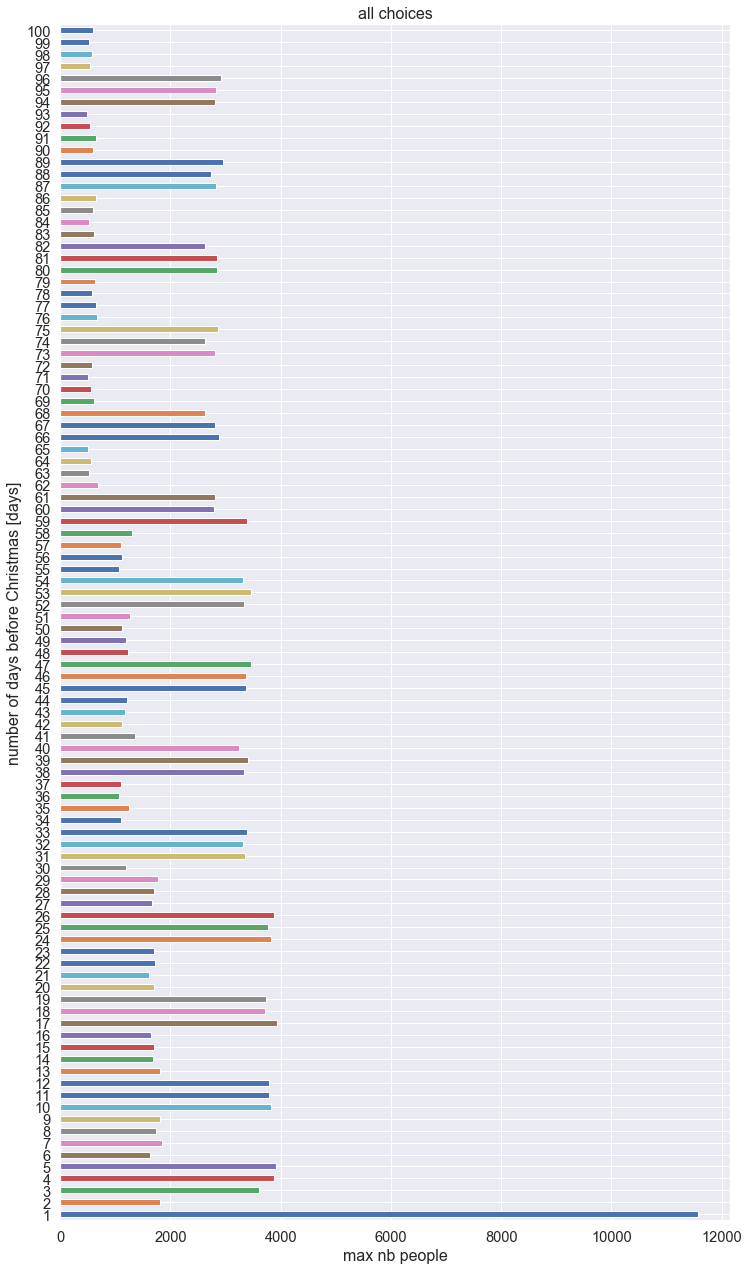

In [196]:
fig = plt.figure(figsize=(12, 22)) 
ax1 = fig.gca()
df_day["all_choices"].plot.barh(ax=ax1)
ax1.set_xlabel("max nb people")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("all choices");

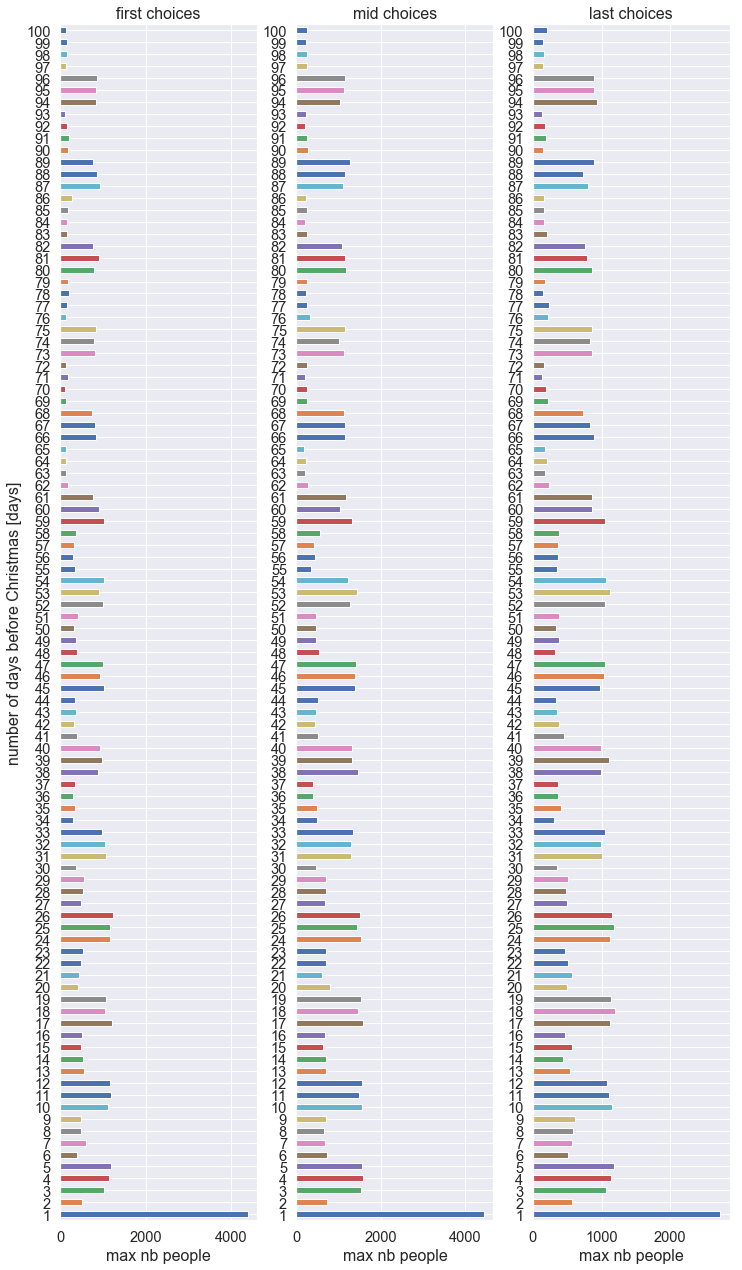

In [197]:
fig = plt.figure(figsize=(12, 22)) 
#plt.title("potential people vs choices")

ax1 = fig.add_subplot(1,3,1)
df_day["first_choices"].plot.barh(ax=ax1)
ax1.set_xlabel("max nb people")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("first choices")

ax2 = fig.add_subplot(1,3,2)
df_day["mid_choices"].plot.barh(ax=ax2)
ax2.set_xlabel("max nb people")
ax2.set_title("mid choices")

ax3 = fig.add_subplot(1,3,3)
df_day["last_choices"].plot.barh(ax=ax3)
ax3.set_xlabel("max nb people")
ax3.set_title("last choices");

### Creation of probality matrix

In [198]:
df_prob_day = pd.DataFrame(df_day["all_choices"])
df_prob_day["prob"] = 1/df_prob_day["all_choices"]
df_prob_day["prob"] = df_prob_day["prob"] / df_prob_day["prob"].sum()
df_prob_day["prob"].sum()

1.0

In [199]:
df_prob_day.head()

,all_choices,prob
1,11568,0.001098
2,1806,0.007036
3,3607,0.003523
4,3872,0.003282
5,3907,0.003252


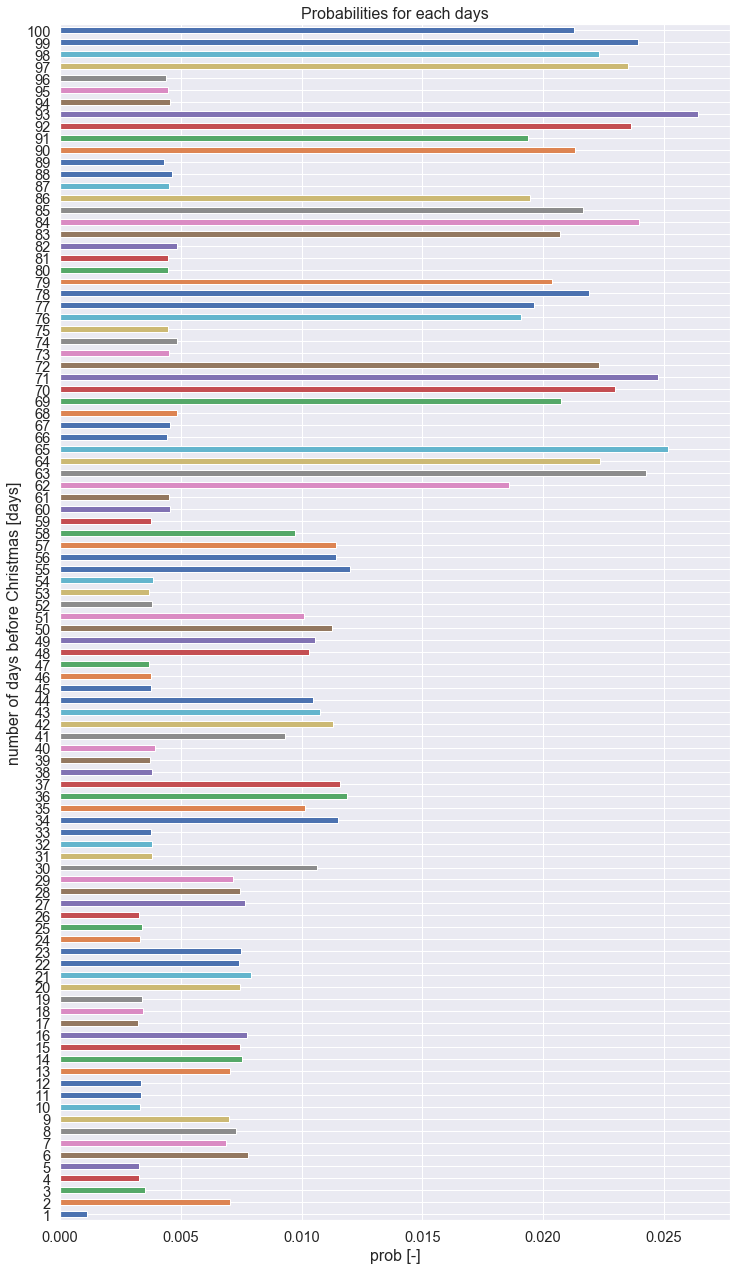

In [200]:
#df_prob_day["prob"].plot.barh()
fig = plt.figure(figsize=(12, 22)) 
ax1 = fig.gca()
df_prob_day["prob"].plot.barh(ax=ax1)
ax1.set_xlabel("prob [-]")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("Probabilities for each days");

## Explore family choice cost

In [174]:
def cost_family(n=1, choice=0):
    # Calculate the penalty for not getting top preference
    penalty = 0
    if choice == 0:
        penalty += 0
    elif choice == 1:
        penalty += 50
    elif choice == 2:
        penalty += 50 + 9 * n
    elif choice == 3:
        penalty += 100 + 9 * n
    elif choice == 4:
        penalty += 200 + 9 * n
    elif choice == 5:
        penalty += 200 + 18 * n
    elif choice == 6:
        penalty += 300 + 18 * n
    elif choice == 7:
        penalty += 300 + 36 * n
    elif choice == 8:
        penalty += 400 + 36 * n
    elif choice == 9:
        penalty += 500 + 36 * n + 199 * n
    else:
        penalty += 500 + 36 * n + 398 * n
        
    return penalty

### Evolution of cost by number of people into family

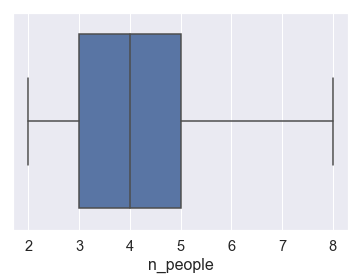

In [175]:
ax = sns.boxplot(x=data["n_people"])


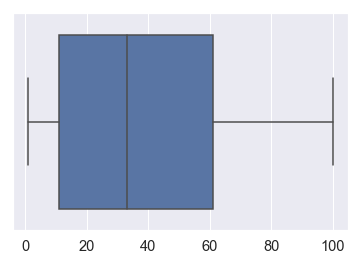

In [176]:
ax = sns.boxplot(data)

In [177]:
df_fam_cost = pd.DataFrame(index = np.array(range(np.min(data["n_people"]),
                            np.max(data["n_people"]) + 1)),
            columns=['choice_{}'.format(n_choice) for n_choice in range(0, 11)])
df_fam_cost["n"] = df_fam_cost.index
df_fam_cost

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10,n
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8


In [178]:
df_fam_cost["choice_0"] = df_fam_cost["n"].apply(cost_family, args=(0,))
df_fam_cost["choice_1"] = df_fam_cost["n"].apply(cost_family, args=(1,))
df_fam_cost["choice_2"] = df_fam_cost["n"].apply(cost_family, args=(2,))
df_fam_cost["choice_3"] = df_fam_cost["n"].apply(cost_family, args=(3,))
df_fam_cost["choice_4"] = df_fam_cost["n"].apply(cost_family, args=(4,))
df_fam_cost["choice_5"] = df_fam_cost["n"].apply(cost_family, args=(5,))
df_fam_cost["choice_6"] = df_fam_cost["n"].apply(cost_family, args=(6,))
df_fam_cost["choice_7"] = df_fam_cost["n"].apply(cost_family, args=(7,))
df_fam_cost["choice_8"] = df_fam_cost["n"].apply(cost_family, args=(8,))
df_fam_cost["choice_9"] = df_fam_cost["n"].apply(cost_family, args=(9,))
df_fam_cost["choice_10"] = df_fam_cost["n"].apply(cost_family, args=(10,))
df_fam_cost

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10,n
2,0,50,68,118,218,236,336,372,472,970,1368,2
3,0,50,77,127,227,254,354,408,508,1205,1802,3
4,0,50,86,136,236,272,372,444,544,1440,2236,4
5,0,50,95,145,245,290,390,480,580,1675,2670,5
6,0,50,104,154,254,308,408,516,616,1910,3104,6
7,0,50,113,163,263,326,426,552,652,2145,3538,7
8,0,50,122,172,272,344,444,588,688,2380,3972,8


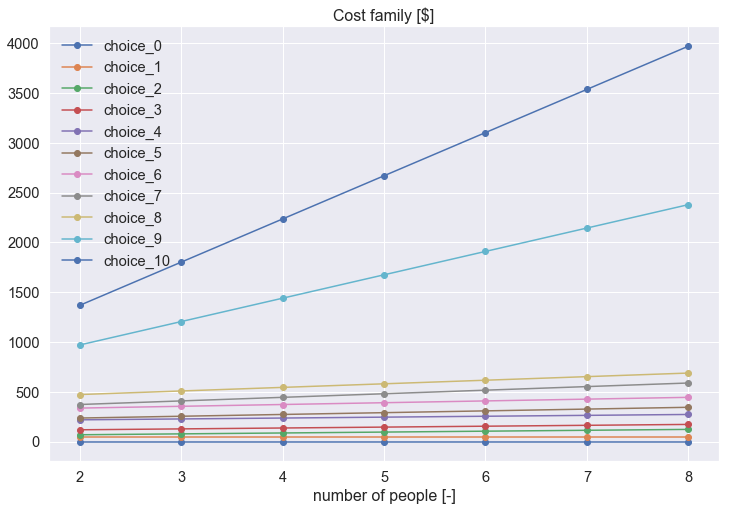

In [179]:
fig = plt.figure(figsize=(12, 8))
plt.title("Cost family [$]")
list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 11)]

for choice in list_choice:
    plt.plot(df_fam_cost["n"], df_fam_cost[choice], '-o', label=choice)
plt.legend(loc='upper left');

ax = fig.gca()
ax.set_xlabel("number of people [-]");

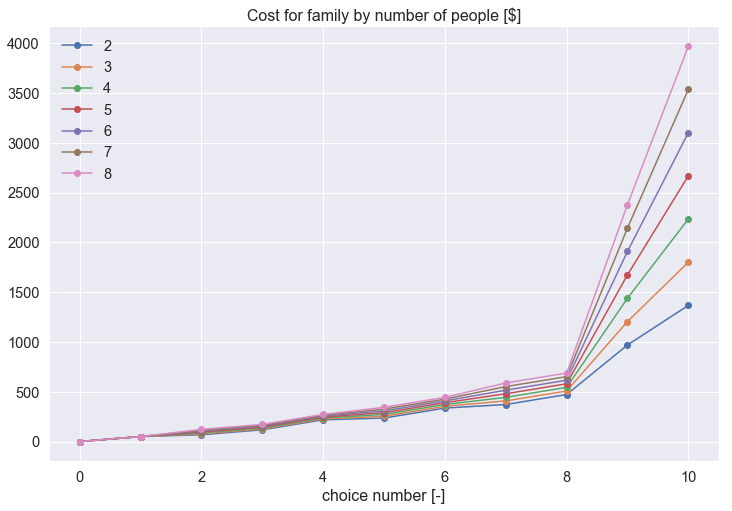

In [180]:
fig = plt.figure(figsize=(12, 8))
plt.title("Cost for family by number of people [$]")
list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 11)]

for n in df_fam_cost["n"]:
    plt.plot(range(0, df_fam_cost.filter(items=list_choice).shape[1]), 
        np.array(df_fam_cost.filter(items=list_choice).filter(items=[n], 
                                                              axis=0))[0],
             '-o', label=n)
plt.legend(loc='upper left');

ax = fig.gca()
ax.set_xlabel("choice number [-]");

### Creation of probability matrix

In [191]:
def create_df_fam_cost_prob(df_fam_cost, p_min=0.03, p_max=0.1):
    # For genetic algo, for start population or mutation,
    # try to assign probabilities of choice for each possibilities : 
    # from  choice 0 to 10.
    list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 
                                                        CHOICE_RANGE_MAX + 1)]
    df_prob = df_fam_cost.filter(items=list_choice)
    vect_penalty = [0, np.max(np.max(df_prob))]
    print("vect_penalty: ", vect_penalty)
    vect_prob = [p_max, p_min]
    print("vect_prob", vect_prob)
    # family : number of people
    df_prob = df_prob.applymap(lambda x: np.interp(x, vect_penalty, vect_prob))
    for indice in df_prob.index:
        df_prob.loc[indice] = df_prob.loc[indice]/df_prob.loc[indice].sum()
    return df_prob  



#### p max = 0.1, p min = 0.03

In [336]:
#df_prob = create_df_fam_cost_prob(df_fam_cost)
#df_prob

vect_penalty:  [0, 3972]
vect_prob [0.1, 0.03]


,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10
2,0.097481,0.096622,0.096313,0.095454,0.093736,0.093427,0.091709,0.091090,0.089372,0.080817,0.073980
3,0.098846,0.097975,0.097505,0.096634,0.094892,0.094422,0.092680,0.091739,0.089997,0.077855,0.067455
4,0.100250,0.099367,0.098731,0.097848,0.096081,0.095445,0.093678,0.092406,0.090639,0.074809,0.060746
5,0.101695,0.100799,0.099992,0.099096,0.097304,0.096498,0.094705,0.093092,0.091300,0.071675,0.053843
6,0.103182,0.102272,0.101291,0.100381,0.098563,0.097581,0.095763,0.093799,0.091980,0.068450,0.046738
7,0.104713,0.103790,0.102627,0.101705,0.099859,0.098697,0.096851,0.094526,0.092681,0.065129,0.039423
8,0.106290,0.105353,0.104004,0.103068,0.101195,0.099846,0.097973,0.095275,0.093402,0.061708,0.031887


#### p max = 1, p min = 0.01

In [192]:
df_prob = create_df_fam_cost_prob(df_fam_cost, p_min=0.01, p_max=1)
df_prob

vect_penalty:  [0, 3972]
vect_prob [1, 0.01]


,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10
2,0.100491,0.099238,0.098787,0.097535,0.095030,0.094580,0.092075,0.091173,0.088669,0.076195,0.066227
3,0.102556,0.101278,0.100588,0.099310,0.096753,0.096063,0.093507,0.092127,0.089571,0.071754,0.056494
4,0.104708,0.103403,0.102463,0.101158,0.098549,0.097609,0.094999,0.093120,0.090511,0.067127,0.046353
5,0.106952,0.105619,0.104419,0.103087,0.100421,0.099221,0.096556,0.094156,0.091491,0.062301,0.035777
6,0.109294,0.107932,0.106461,0.105099,0.102375,0.100904,0.098180,0.095238,0.092514,0.057264,0.024738
7,0.111742,0.110349,0.108594,0.107202,0.104417,0.102662,0.099877,0.096368,0.093583,0.052001,0.013205
8,0.114301,0.112877,0.110825,0.109401,0.106552,0.104501,0.101652,0.097550,0.094701,0.046497,0.001143


In [364]:
# save
joblib.dump(df_prob, PATH_TO_SAVE_DATA + '/df_prob.pkl')

['../../data/df_prob_2.pkl']

## Creation of days probabilities by family

In [233]:
df_prob_fam = create_df_prob_day_fam_optim(df_prob_day, df_prob)

In [234]:
df_prob_fam.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
family_id,,,,,,,,,,,,,,,,,,,,,
0,0.000562,0.003601,0.001803,0.001680,0.001665,0.003993,0.003516,0.003738,0.003578,0.048027,...,0.009930,0.012112,0.013522,0.002321,0.002294,0.002234,0.012045,0.011431,0.012249,0.010895
1,0.000562,0.003601,0.001803,0.054608,0.053444,0.051658,0.003516,0.003738,0.003578,0.001698,...,0.009930,0.012112,0.013522,0.002321,0.002294,0.002234,0.012045,0.011431,0.012249,0.010895
2,0.000565,0.003620,0.001813,0.001689,0.001673,0.004014,0.003534,0.003757,0.003596,0.049819,...,0.009982,0.012175,0.013593,0.002333,0.002306,0.002246,0.012107,0.011490,0.012313,0.063720
3,0.051653,0.055604,0.001822,0.001697,0.001682,0.052943,0.003552,0.003776,0.049467,0.001715,...,0.010032,0.012236,0.013661,0.002345,0.053636,0.052695,0.012168,0.011548,0.012375,0.011007
4,0.053490,0.003601,0.051766,0.001680,0.001665,0.003993,0.003516,0.003738,0.003578,0.001698,...,0.009930,0.012112,0.065301,0.002321,0.002294,0.002234,0.012045,0.011431,0.012249,0.010895


In [413]:
# save
joblib.dump(df_prob_fam, PATH_SAVE_PROB_FAM)

['../../data//df_prob_fam.pkl']

## From multiple baselines

### Find several baseline / seed source

#### Create ranges

In [58]:
submission = pd.read_csv(fpath, index_col='family_id')

In [59]:
submission.shape[0]

5000

In [43]:
NB_FIRST_SEED = 10
df_range = pd.DataFrame(index=range(0, NB_FIRST_SEED), 
                        columns=range(0, submission.shape[0]))

df_range.loc[0] = np.array(range(0, submission.shape[0]))

df_range.loc[1] = np.array(range(submission.index.max(), 
                                 submission.index.min()-1, -1))  

In [44]:
start_pt = np.linspace(0, submission.shape[0], 
                       num=int((NB_FIRST_SEED)/2)+1, dtype="int")
start_pt = start_pt[1:-1]
start_pt

array([1000, 2000, 3000, 4000])

In [45]:
indice = 2
for st_id, _ in enumerate(start_pt):
    df_range.loc[indice+st_id] = np.concatenate((np.array(range(start_pt[st_id], 
                                                submission.shape[0])), 
               np.array(range(0, start_pt[st_id]))))

indice = 6
for st_id, _ in enumerate(start_pt):
    df_range.loc[indice+st_id] = \
        np.concatenate((range(start_pt[st_id], 0-1, -1), 
                range(submission.shape[0]-1, start_pt[st_id], -1)))

df_range    

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
1,4999,4998,4997,4996,4995,4994,4993,4992,4991,4990,...,9,8,7,6,5,4,3,2,1,0
2,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,990,991,992,993,994,995,996,997,998,999
3,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
4,3000,3001,3002,3003,3004,3005,3006,3007,3008,3009,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
5,4000,4001,4002,4003,4004,4005,4006,4007,4008,4009,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
6,1000,999,998,997,996,995,994,993,992,991,...,1010,1009,1008,1007,1006,1005,1004,1003,1002,1001
7,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,...,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001
8,3000,2999,2998,2997,2996,2995,2994,2993,2992,2991,...,3010,3009,3008,3007,3006,3005,3004,3003,3002,3001
9,4000,3999,3998,3997,3996,3995,3994,3993,3992,3991,...,4010,4009,4008,4007,4006,4005,4004,4003,4002,4001


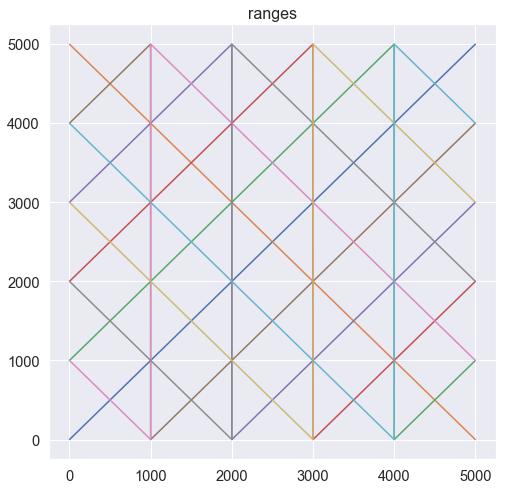

In [63]:
fig = plt.figure(figsize=(8, 8))
plt.title("ranges")
for indice in range(0, df_range.shape[0]):
    plt.plot(df_range.loc[indice])


#### Evaluate baselines & save

In [64]:
# Create baselines

# optimized version

t_fit_0 = time.time()
choice_matrix = data.loc[:, 'choice_0': 'choice_9'].values
# Start with the sample submission values
submission = pd.read_csv(fpath, index_col='family_id')
best = submission['assigned_day'].values
start_cost = cost_function_optim(best)
print("Start cost: ", start_cost)

for indice in df_range.index:
    # initiate first inviduate 
    new = best.copy()
    cost_best = start_cost
    # choose current range in df_range
    range_optim = df_range.loc[indice]
    # loop over each family with this current range
    for fam_id in range_optim:
        # loop over each family choice
        for pick in range(10):
            #day = choice_dict[f'choice_{pick}'][fam_id]
            day = choice_matrix[fam_id, pick]
            temp = new.copy()
            temp[fam_id] = day # add in the new pick
            cost_curr = cost_function_optim(temp) # test cost
            if cost_curr < cost_best:
                new = temp.copy()
                cost_best = cost_curr
                #print("Current best cost: ", cost_best)

    submission['assigned_day'] = new
    score = cost_function_optim(new)
    submission.to_csv(f'submission_range{indice}.csv')
    print(f'Score: {score}')

t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

Start cost:  10641498.403135022
Score: 672254.0276683343
Score: 627484.8599699548
Score: 587514.8278465485
Score: 569290.6931284127
Score: 548070.4010206381
Score: 543886.1774036238
Score: 542416.1088397022
Score: 541522.3543918737
Score: 536024.9660658052
Score: 535295.5188186927
Timing:  15.611806869506836


### Generate first population

#### Load

In [65]:
df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)
df_prob = joblib.load(PATH_TO_SAVE_DATA + '/df_prob.pkl')

#### Method 2:  Choice by Choices

In [66]:
# HYPERPARAMETERS
DELTA_CHOICE = 1
R_FIRST_MUT = 0.01
NB_FIRST_POP = 2000

# patch to optimize mutation fonction:
arr_prob = np.array(df_prob)
arr_prob_fam = np.array(df_prob_fam.astype("float"))

nb_indiv_done = 0
nb_range = df_range.index.shape[0]
for i_seed in df_range.index:
    # choose number of indiv.
    nb_indiv_curr = np.floor(NB_FIRST_POP/df_range.shape[0])
    nb_indiv_done += nb_indiv_curr
    if i_seed == nb_range-1:
        if NB_FIRST_POP % nb_range != 0:
            nb_indiv_curr += NB_FIRST_POP % nb_range
    nb_indiv_curr = int(nb_indiv_curr)
    print("# {} / nb_indiv_curr: {} / done: {}".format(i_seed, nb_indiv_curr, 
                                                       nb_indiv_done))
    # load best indiv in range #i_seed
    seed_indiv = pd.read_csv(f'submission_range{i_seed}.csv')
    # generate sub-pop 
    df_pop_curr = generate_pop_choices(seed_indiv=seed_indiv, 
                                       nb_pop=nb_indiv_curr, 
                                       r_mut=R_FIRST_MUT)
    # add sub-pop to pop
    if i_seed == 0:
        df_pop = df_pop_curr
    else:
        df_pop = df_pop.append(df_pop_curr, ignore_index=True)

print("df_pop.shape: ", df_pop.shape) 
df_pop.head()

# 0 / nb_indiv_curr: 200 / done: 200.0
Generating population : 
nb_pop:  200
r_mut:  0.01
Generation population is done.
Timing :  61.13574767112732
# 1 / nb_indiv_curr: 200 / done: 400.0
Generating population : 
nb_pop:  200
r_mut:  0.01
Generation population is done.
Timing :  55.37708783149719
# 2 / nb_indiv_curr: 200 / done: 600.0
Generating population : 
nb_pop:  200
r_mut:  0.01
Generation population is done.
Timing :  63.276259899139404
# 3 / nb_indiv_curr: 200 / done: 800.0
Generating population : 
nb_pop:  200
r_mut:  0.01
Generation population is done.
Timing :  59.66408610343933
# 4 / nb_indiv_curr: 200 / done: 1000.0
Generating population : 
nb_pop:  200
r_mut:  0.01
Generation population is done.
Timing :  59.476869106292725
# 5 / nb_indiv_curr: 200 / done: 1200.0
Generating population : 
nb_pop:  200
r_mut:  0.01
Generation population is done.
Timing :  59.412047147750854
# 6 / nb_indiv_curr: 200 / done: 1400.0
Generating population : 
nb_pop:  200
r_mut:  0.01
Generation

family_id,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
1,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
2,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
3,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13
4,52,26,100,2,53,59,88,25,18,1,...,61,29,90,62,52,16,88,32,67,13


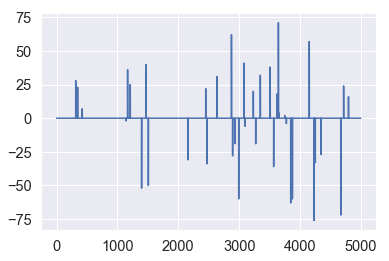

In [67]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

#### Save pop

In [68]:
# save
joblib.dump(df_pop,
            PATH_TO_SAVE_DATA + '/df_pop_choices{}_fs{}_rfm{}_dc{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_CHOICE),
           compress=True)

['../../data/df_pop_choices2000_fs10_rfm0.01_dc1.pkl']

## Run with pop by choices

### Evaluation #1

#### Load

In [413]:
df_prob_fam = joblib.load(PATH_TO_SAVE_DATA + '/df_prob_fam.pkl')
df_prob = joblib.load(PATH_TO_SAVE_DATA + '/df_prob.pkl')

NB_FIRST_SEED = 10
DELTA_CHOICE = 1
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000
# load 
df_pop = joblib.load(PATH_TO_SAVE_DATA + '/df_pop_choices{}_fs{}_rfm{}_dc{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_CHOICE))

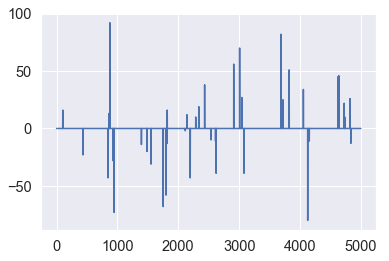

In [414]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

#### Initialize costs

In [415]:
# create cost dataFrame for all population
t_1 = time.time()
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function_optim(df_pop.loc[indice].values)
print(time.time()-t_1)

df_cost.sort_values(by="cost").head(10)


0.8911471366882324


,cost
900,535295.518819
800,536024.966066
700,541522.354392
600,542416.108840
500,543886.177404
400,548070.401021
300,569290.693128
200,587514.827847
100,627484.859970
0,672254.027668


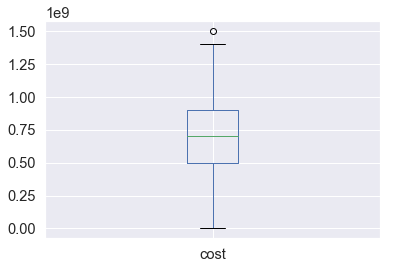

In [416]:
df_cost.boxplot()

In [418]:
np.unique(arr_pop, axis=0)

array([[ 52,  26, 100, ...,  32,  92,  13],
       [ 52,  26, 100, ...,  32,  92,  13],
       [ 52,  26, 100, ...,  32,  92,  13],
       ...,
       [ 52,  26, 100, ...,  32,  92,  13],
       [ 52,  26, 100, ...,  32,  92,  13],
       [ 52,  26, 100, ...,  32,  92,  13]])

####  Loop over generations

In [417]:
# patch to optimize mutation fonction:
arr_prob = np.array(df_prob)
arr_prob_fam = np.array(df_prob_fam.astype("float"))

# HYPERPARAMETERS
nb_seeds = 10 # number of seed sources : keep them along epochs
NB_MAX_EPOCHS = 10000
R_POP_LOST = 0.01
R_POP_MUT = 0.10
DELTA_CHOICE = 2

# DISPLAY PARAM
flag_prompt = False
prompt_freq = 100

# LOOP OVER GENERATIONS 
list_best_cost = []
t_fit_0 = time.time()
for gen_id in range(0, NB_MAX_EPOCHS):
    
    t_epoch_0 = time.time()
    if flag_prompt:
        t_lost_0 = time.time()

    # Keep the best nb_seeds indiv. 
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(1, df_cost.shape[0]+1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    for indice in range(0, nb_seeds):
        list_name_best.append(df_cost_sort.iloc[indice].name)
    df_best = df_pop.loc[list_name_best]

    ############
    # LOST WORST INDIV.
    # Lost indiv. in population : R_POP_LOST
    # select random of R_POP_LOST of population 
    #   with prob = proportional to their rank
    df_cost_sort["prob"] = 1/df_cost_sort["rank"]
    df_cost_sort.iloc[0:nb_seeds,2] = 0 # 0 prob for the best (added after)
    df_cost_sort["prob"] = df_cost_sort["prob"] / df_cost_sort["prob"].sum()
    # determine  number survivors (have to be an even number)
    nb_survivor = int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - 2 * nb_seeds)
    if (nb_survivor + 2 * nb_seeds) % 2 != 0:
        nb_survivor += 1
    # select ramdomly survivors  (prob=1/rank)
    # keep best indiv
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    # add best ones in first position
    vect_survivor = np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), 
                                    vect_survivor))

    df_pop = df_pop.loc[vect_survivor] 
    
    if flag_prompt:
        t_lost_1 = time.time()
        print("Timing lost: ", t_lost_1 - t_lost_0)
    if flag_prompt:
        t_cross_0 = time.time()
    ############
    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 
    # create pairs : ramdomly
    
    arr_pop = np.array(df_pop) # df_pop = f(indiv., families)
    
    arr_pop = generate_crossing(arr_pop)
    
    if flag_prompt:
        t_cross_1 = time.time()
        print("Timing cross: ", t_cross_1 - t_cross_0)
    ############
    # MUTATION
    # among pop, number of mutation = R_POP_MUT * number of indiv
    # arr_pop or df_pop = f(indiv, family)
    
    # nb of indiv. mutated :
    if flag_prompt:
        t_mut_0 = time.time()
    nb_mut = int(R_POP_MUT*arr_pop.shape[0])
    # indice of mutated indiv.
    indice_mut = np.random.choice(range(0, arr_pop.shape[0]), size=nb_mut)
    # number of family who mutate  for each mutated indiv. : R_MUT * nb families
    nb_fam_mut = int(R_MUT*arr_pop.shape[1])
    # loop over indice of mutated indiv to apply mutation to number of family
    # who mutated :
    for indice in indice_mut:
        fam_mut = np.random.choice(range(0, arr_pop.shape[1]), size=nb_fam_mut)
        for fam_id in fam_mut:
            arr_pop[indice, fam_id] = \
                mutation_day_optim(arr_pop[indice, fam_id], fam_id, nb_mut=1, 
                                        flag_prob=True)
                #np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))
            

    # add the best ones
    arr_pop = np.append(arr_pop, np.array(df_best), axis=0)
    df_pop = pd.DataFrame(data=arr_pop)
    #df_pop = df_pop.append(df_best, ignore_index=True)
    if flag_prompt:
        t_mut_1 = time.time()
        print("Timing mutation: ", t_mut_1 - t_mut_0)
    ############
    # EVALUATION
    # create cost dataFrame for all population
    if flag_prompt:
        t_eval_0 = time.time()
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 
    
    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = \
            cost_function_optim(arr_pop[indice,:])

    if flag_prompt:
        t_eval_1 = time.time()
        print("Timing eval: ", t_eval_1 - t_eval_0)
    
    t_epoch_1 = time.time()
    if (flag_prompt) | (gen_id % prompt_freq == 0):
        print("GEN. #{} / cost: {} / nb. pop: {} / timing: {}".format(gen_id, 
                        df_cost.sort_values(by="cost").head(1)["cost"].values,                      
                                                       df_pop.shape[0],
                                                      t_epoch_1 - t_epoch_0))
        print("Max Same indiv nb : ", find_max_same_indiv(arr_pop))

#timing 
t_fit_1 = time.time()
print("END:")
print("LAST GEN. #{} / cost: {} / nb. pop: {} / timing Total: {}".format(gen_id, 
                        df_cost.sort_values(by="cost").head(1)["cost"].values,                      
                                                       df_pop.shape[0],
                                                      t_fit_1 - t_fit_0)) 
# figure
fig = plt.figure(figsize=(12, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

GEN. #0 / cost: [535295.51881869] / nb. pop: 990 / timing: 1.591810941696167
Max Same indiv nb :  0
GEN. #100 / cost: [535295.51881869] / nb. pop: 368 / timing: 0.08088183403015137
Max Same indiv nb :  10
GEN. #200 / cost: [535295.51881869] / nb. pop: 134 / timing: 0.04061102867126465
Max Same indiv nb :  20
GEN. #300 / cost: [534066.8789234] / nb. pop: 100 / timing: 0.035526275634765625
Max Same indiv nb :  23
GEN. #400 / cost: [534060.57561675] / nb. pop: 100 / timing: 0.025150775909423828
Max Same indiv nb :  30
GEN. #500 / cost: [534044.96446768] / nb. pop: 100 / timing: 0.024233102798461914
Max Same indiv nb :  18
GEN. #600 / cost: [534031.47090913] / nb. pop: 100 / timing: 0.026170969009399414
Max Same indiv nb :  28
GEN. #700 / cost: [534031.47090913] / nb. pop: 100 / timing: 0.02654886245727539
Max Same indiv nb :  40
GEN. #800 / cost: [534031.47090913] / nb. pop: 100 / timing: 0.025310039520263672
Max Same indiv nb :  25
GEN. #900 / cost: [533999.12126298] / nb. pop: 100 / tim

KeyboardInterrupt: 

In [754]:
print(df_cost.sort_values(by="cost").head(1)["cost"].values)

[197363.04481434]


#### Save results

In [755]:
# POP
joblib.dump(df_pop,
    PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0,0])),
           compress=True)
# COST
joblib.dump(df_cost,
    PATH_TO_SAVE_DATA + \
            '/df_cost_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0,0])),
           compress=True)

# submission
submission_final = pd.DataFrame(columns=["assigned_day"])
submission_final["assigned_day"] = \
    df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name]
submission_final.to_csv("submission_{}.csv".format(
    df_cost.sort_values(by="cost").iloc[0,0]))           
print("Submission saved here :", "submission_{}.csv".format(
    df_cost.sort_values(by="cost").iloc[0,0]))

joblib.dump(submission_final,
    PATH_TO_SAVE_DATA + \
            '/submission_pop{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0,0])),
           compress=True)

joblib.dump(list_best_cost,
    PATH_TO_SAVE_DATA + \
            '/list_best_cost{}_fs{}_rfm{}_dc{}_rm{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0,0])),
           compress=True)

Submission saved here : submission_197363.04481434217.csv


['../../data/list_best_cost1000_fs10_rfm0.01_dc2_rm0.1_gen200000_s197363.pkl']

#### Explore cost

In [381]:
df_pop = joblib.load(PATH_TO_SAVE_DATA + \
                     '/df_pop1000_fs10_rfm0.01_dc2_rm0.1_gen200000_s197363.pkl')

df_cost = joblib.load(PATH_TO_SAVE_DATA + \
                     '/df_cost_pop1000_fs10_rfm0.01_dc2_rm0.1_gen200000_s197363.pkl')

In [383]:
df_cost_sort = df_cost.sort_values(by="cost")
df_cost_sort["inv_rank"] = range(df_cost.shape[0]+1, 1, -1)
list_best_cost.append(df_cost_sort.iloc[0]["cost"])
list_name_best = []
for indice in range(0, NB_BEST_KEEP):
    list_name_best.append(df_cost_sort.iloc[indice].name)
df_best = df_pop.loc[list_name_best]
df_cost_best = df_cost.loc[list_name_best]

In [386]:
df_best.drop_duplicates().shape

(1, 5000)

In [379]:
print("Max Same indiv nb : ", find_max_same_indiv(df_pop.values))

Max Same indiv nb :  21


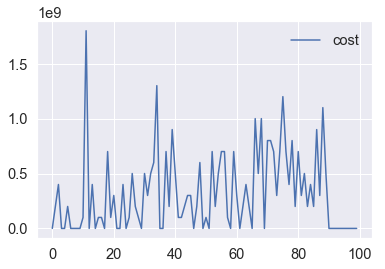

In [762]:
df_cost.plot()

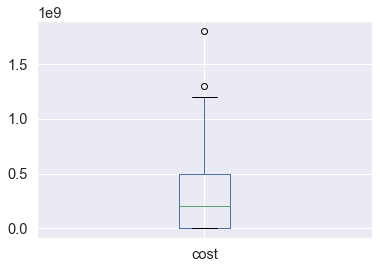

In [763]:
df_cost.boxplot()

In [764]:
df_cost.describe()

,cost
count,1.000000e+02
mean,3.202015e+08
std,3.590158e+08
min,1.973630e+05
25%,1.977991e+05
50%,2.001993e+08
75%,5.002050e+08
max,1.800217e+09


### Eval with new crossing prob

#### Load

In [98]:
#df_pop = joblib.load(PATH_TO_SAVE_DATA + \
#            '/df_pop1000_fs10_rfm0.01_dc2_rm0.1_nk_100_gen20000_s287853.pkl')

Max Same indiv nb :  0


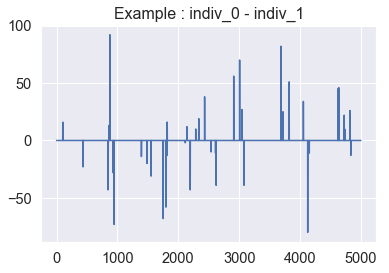

In [99]:
df_prob_fam = joblib.load(PATH_TO_SAVE_DATA + '/df_prob_fam.pkl')
df_prob = joblib.load(PATH_TO_SAVE_DATA + '/df_prob.pkl')

NB_FIRST_SEED = 10
DELTA_CHOICE = 1
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000
# load 
df_pop = joblib.load(PATH_TO_SAVE_DATA + '/df_pop_choices{}_fs{}_rfm{}_dc{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_CHOICE))


plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])
plt.title("Example : indiv_0 - indiv_1")
print("Max Same indiv nb : ", find_max_same_indiv(df_pop.values))

In [100]:
# prepare data 
choice_matrix = data.loc[:, 'choice_0': 'choice_9'].values
# ranges  f(families, num range)
arr_range = df_range.values # f(num range, families)

#### Initialize costs

Timing:  1.070836067199707


,cost
900,535295.518819
800,536024.966066
700,541522.354392
600,542416.108840
500,543886.177404
400,548070.401021
300,569290.693128
200,587514.827847
100,627484.859970
0,672254.027668


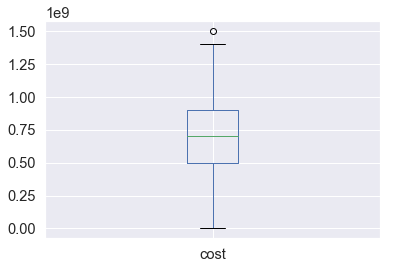

In [101]:
# create cost dataFrame for all population
t_1 = time.time()
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function_optim(df_pop.loc[indice].values)
print("Timing: ", time.time()-t_1)

df_cost.boxplot()

df_cost.sort_values(by="cost").head(10)


#### Selection probability

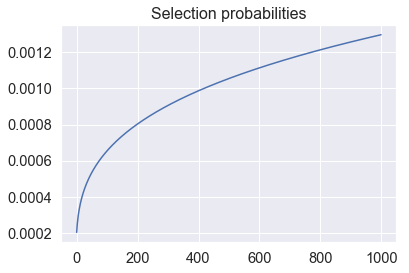

In [102]:
# Prob for indiv = inverse rank * POW_SELECTION
POW_SELECTION = 0.3

df_cost_sort = df_cost.sort_values(by="cost")
df_cost_sort["rank"] = range(df_cost.shape[0]+1,1,-1 )
arr_select_prob = np.zeros(df_pop.shape[0])
arr_select_prob[df_cost_sort.index] = df_cost_sort["rank"].values
arr_select_prob = (arr_select_prob)**POW_SELECTION
arr_select_prob = arr_select_prob / np.sum(arr_select_prob)
plt.plot(np.sort(arr_select_prob))
plt.title("Selection probabilities");

####  Loop over generations

In [103]:
# patch to optimize mutation fonction:
arr_prob = np.array(df_prob)
arr_prob_fam = np.array(df_prob_fam.astype("float"))

# HYPERPARAMETERS
NB_MAX_EPOCHS = 10000
R_POP_MUT = 0.1 # default : 0.10
R_MUT = 0.01 # default : 0.01
DELTA_CHOICE = 2
NB_BEST_KEEP = 20 # NEW PARAM : how much best one to keep
#POW_SELECTION = 0.3

# DISPLAY PARAM
flag_prompt = False
prompt_freq = 100 #100

# BOOST PARAM
flag_boost = False
boost_freq = 2000

# LOOP OVER GENERATIONS 
list_best_cost = []
t_fit_0 = time.time()
for gen_id in range(0, NB_MAX_EPOCHS):
    
    t_epoch_0 = time.time()
    if flag_prompt:
        t_lost_0 = time.time()

    # Keep the best nb_seeds indiv. 
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["inv_rank"] = range(df_cost.shape[0]+1, 1, -1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    for indice in range(0, NB_BEST_KEEP):
        list_name_best.append(df_cost_sort.iloc[indice].name)
    
    df_best = df_pop.loc[list_name_best]
    df_cost_best = df_cost.loc[list_name_best]
    
    '''    
    # AVOID DUPLICATE INDIV
    df_best["cost"] = df_cost_best["cost"]
    df_best.drop_duplicates(subset=["cost"], inplace=True)
    df_best.drop(columns=["cost"], inplace=True)
    df_cost_best.drop_duplicates(subset=["cost"], inplace=True)
    '''

    ############
    # SELECTION  
    # calculation of probabilities for crossing next generation 
    # prob =  (1/rank)^0.3
    arr_select_prob = np.zeros(df_pop.shape[0])
    arr_select_prob[df_cost_sort.index] = df_cost_sort["inv_rank"].values
    arr_select_prob = (arr_select_prob)**POW_SELECTION 
    arr_select_prob = arr_select_prob / np.sum(arr_select_prob)
    
    '''
    # determine  number survivors (have to be an even number)
    nb_survivor = int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - 2 * nb_seeds)
    if (nb_survivor + 2 * nb_seeds) % 2 != 0:
        nb_survivor += 1
    # select ramdomly survivors  (prob=1/rank)
    # keep best indiv
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    # add best ones in first position
    vect_survivor = np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), 
                                    vect_survivor))

    df_pop = df_pop.loc[vect_survivor] 
    '''
    
    if flag_prompt:
        t_lost_1 = time.time()
        print("Timing lost: ", t_lost_1 - t_lost_0)
    
    if flag_prompt:
        t_cross_0 = time.time()
    ############
    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 
    # create pairs : ramdomly

    arr_pop = np.array(df_pop) # df_pop = f(indiv., families)

    # crossing with more prob for best indiv.
    # number of new children = N pop - N best to keep same nb of indiv each gen.
    #nb_cross = NB_FIRST_POP - NB_BEST_KEEP - NB BOOST indiv
    nb_cross = NB_FIRST_POP - NB_BEST_KEEP - nb_indiv_boost
    # reset nb boost indiv
    if nb_indiv_boost > 0:
        nb_indiv_boost = 0
        
    arr_pop = generate_crossing_prob(arr_pop, p=arr_select_prob, 
                                     n_indiv=nb_cross)

    #print("Max Same indiv nb after crossing : ", find_max_same_indiv(arr_pop))
    
    if flag_prompt:
        t_cross_1 = time.time()
        print("Timing cross: ", t_cross_1 - t_cross_0)
    ############
    # MUTATION
    # among pop, number of mutation = R_POP_MUT * number of indiv
    # arr_pop or df_pop = f(indiv, family)
    
    if flag_prompt:
        t_mut_0 = time.time()
    
    flag_test_mut = True
    
    if flag_test_mut:
        arr_pop = fun_vect_mut(arr_pop)
    else:
        # nb of indiv. mutated :
        nb_mut = int(R_POP_MUT*arr_pop.shape[0])
        # indice of mutated indiv.
        indice_mut = np.random.choice(range(0, arr_pop.shape[0]), size=nb_mut)
        # number of family who mutate for each mutated indiv. : R_MUT * nb families
        nb_fam_mut = int(R_MUT*arr_pop.shape[1])
        # loop over indiv chosen randomly to apply mutation to number of family
        # who mutated :
        for indice in indice_mut:
            fam_mut = np.random.choice(range(0, arr_pop.shape[1]), 
                                       size=nb_fam_mut)
            for fam_id in fam_mut:
                arr_pop[indice, fam_id] = \
                    mutation_day_optim(arr_pop[indice, fam_id], fam_id, 
                                       nb_mut=1, flag_prob=True)
                    #np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))
    
    #print("Max Same indiv nb after mutation : ", find_max_same_indiv(arr_pop))
    
    # add the best ones
    arr_pop = np.append(arr_pop, np.array(df_best), axis=0)
    
    # AVOID DUPLICATE INDIV 
    #arr_pop = np.unique(arr_pop, axis=0)  # replace by cost because too slow
    df_pop = pd.DataFrame(data=arr_pop)
    #print("Max Same indiv nb after add best : ", find_max_same_indiv(arr_pop))

    
    if flag_prompt:
        t_mut_1 = time.time()
        print("Timing mutation: ", t_mut_1 - t_mut_0)
    ############
    # EVALUATION
    # create cost dataFrame for all population
    if flag_prompt:
        t_eval_0 = time.time()
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 
    
    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = \
            cost_function_optim(arr_pop[indice,:])
    
    
    ##########
    # BOOSTING
    #
    # cost of last best submission

    if flag_boost & (gen_id % boost_freq == 0):
        best = df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name].values
    
        arr_sub, arr_score = boost_diff_browsing(choice_matrix=choice_matrix, 
                                             best=best, arr_range=arr_range)
    
        df_new_indiv = pd.DataFrame(data=arr_sub, columns=df_pop.columns)
        nb_indiv_boost = df_new_indiv.shape[0]
        df_pop = df_pop.append(df_new_indiv, ignore_index=True)
    
        df_score = pd.DataFrame(data=arr_score, columns=['cost'])
        df_cost = df_cost.append(df_score, ignore_index=True)
    
    
    # AVOID DUPLICATES BY SAME COST : TEST more speed
    df_cost.drop_duplicates(subset=["cost"], inplace=True)
    df_pop = df_pop.filter(items=df_cost.index, axis=0)
    df_cost.reset_index(drop=True, inplace=True)
    df_pop.reset_index(drop=True, inplace=True)

    if flag_prompt:
        t_eval_1 = time.time()
        print("Timing eval: ", t_eval_1 - t_eval_0)
    
    t_epoch_1 = time.time()
    if (flag_prompt) | (gen_id % prompt_freq == 0):
        print("GEN. #{} / cost: {} / nb. pop: {} / timing: {}".format(gen_id, 
                        df_cost.sort_values(by="cost").head(1)["cost"].values,                      
                                                       df_pop.shape[0],
                                                      t_epoch_1 - t_epoch_0))
        #print("Max Same indiv nb : ", find_max_same_indiv(arr_pop))

#timing 
t_fit_1 = time.time()
print("END:")
print("LAST GEN. #{} / cost: {} / nb. pop: {} / timing Total: {}".format(gen_id, 
                        df_cost.sort_values(by="cost").head(1)["cost"].values,                      
                                                       df_pop.shape[0],
                                                      t_fit_1 - t_fit_0)) 
# figure
fig = plt.figure(figsize=(12, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

Start cost:  535295.5188186927
Baseline #0 Score: 534952.2643792143
Baseline #1 Score: 534784.1063400066
Baseline #2 Score: 534924.6986486969
Baseline #3 Score: 534981.21937734
Baseline #4 Score: 534925.4556780446
Baseline #5 Score: 534764.8742350106
Baseline #6 Score: 534863.7897904352
Baseline #7 Score: 534766.3432873142
Baseline #8 Score: 534934.6789643673
Baseline #9 Score: 534588.0199385034
Timing:  14.772916078567505
GEN. #0 / cost: [534588.0199385] / nb. pop: 1010 / timing: 18.235496044158936
Start cost:  534588.0199385034
Baseline #0 Score: 529855.9019526013
Baseline #1 Score: 534278.8630096033
Baseline #2 Score: 534208.0967204676
Baseline #3 Score: 534186.0017231802
Baseline #4 Score: 534066.4194885589
Baseline #5 Score: 534194.444421682
Baseline #6 Score: 534294.5963362464
Baseline #7 Score: 534365.4290255316
Baseline #8 Score: 534331.4164967218
Baseline #9 Score: 534353.7342564786
Timing:  14.408400058746338
Start cost:  529855.9019526013
Baseline #0 Score: 528208.9559510705

KeyboardInterrupt: 

In [426]:
find_same_indiv(df_best.values)

1

In [428]:
df_cost_best

,cost
699,535295.518819
728,535433.117661
475,536024.966066
729,536074.181207
476,536165.623284
701,536357.992742
730,536398.730334
524,536402.121644
700,536454.068727
710,536668.319730


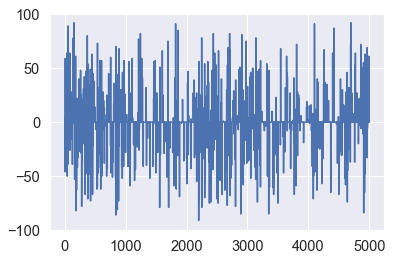

In [429]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

In [39]:
print(df_cost.sort_values(by="cost").head(1)["cost"].values)

[210448.97407208]


#### Save results

In [42]:
# POP
joblib.dump(df_pop,
    PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dc{}_rm{}_nk_{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT,
                NB_BEST_KEEP,
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0,0])),
           compress=True)
# COST
joblib.dump(df_cost,
    PATH_TO_SAVE_DATA + \
            '/df_cost_pop{}_fs{}_rfm{}_dc{}_rm{}_nk_{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT,
                NB_BEST_KEEP,
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0,0])),
           compress=True)

# submission
submission_final = pd.DataFrame(columns=["assigned_day"])
submission_final["assigned_day"] = \
    df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name]
submission_final.to_csv("submission_{}.csv".format(
    df_cost.sort_values(by="cost").iloc[0,0]))           
print("Submission saved here :", "submission_{}.csv".format(
    df_cost.sort_values(by="cost").iloc[0,0]))

joblib.dump(submission_final,
    PATH_TO_SAVE_DATA + \
            '/submission_pop{}_fs{}_rfm{}_dc{}_rm{}_nk_{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT,
                NB_BEST_KEEP,
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0,0])),
           compress=True)

joblib.dump(list_best_cost,
    PATH_TO_SAVE_DATA + \
            '/list_best_cost{}_fs{}_rfm{}_dc{}_rm{}_nk_{}_gen{}_s{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_CHOICE,
                R_POP_MUT, 
                NB_BEST_KEEP,
                NB_MAX_EPOCHS,
                int(df_cost.sort_values(by="cost").iloc[0,0])),
           compress=True)

Submission saved here : submission_134849.05395844002.csv


['../../data/list_best_cost1000_fs10_rfm0.01_dc2_rm0.1_nk_20_gen10000_s134849.pkl']

#### Explore res

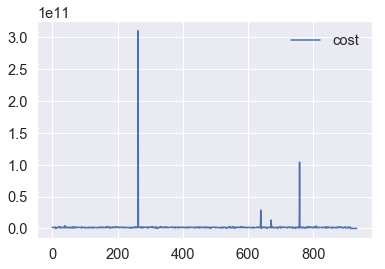

In [404]:
df_cost.plot()

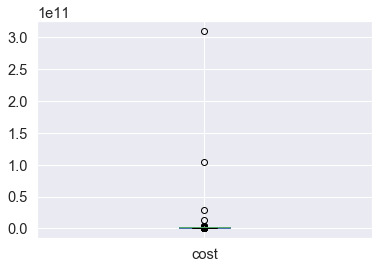

In [405]:
df_cost.boxplot()

In [406]:
df_cost.describe()

,cost
count,9.340000e+02
mean,1.946783e+09
std,1.069271e+10
min,5.352955e+05
25%,1.200612e+09
50%,1.500579e+09
75%,1.708888e+09
max,3.101424e+11


In [766]:
submission_final

,assigned_day
0,52
1,26
2,100
3,2
4,53
5,32
6,88
7,25
8,18
9,88
